# Урок 6. Градиентный бустинг

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X.shape

(442, 10)

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta*coef*alg.predict([x])[0] for alg, coef in zip(trees_list,coef_list)]) for x in X])


В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функицию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [8]:
def deriv(y, z):
    return 2*(y - z)

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [10]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

# %%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [11]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [12]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2959.823489875402
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 9255.51261250112


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [13]:
import matplotlib.pyplot as plt

In [14]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

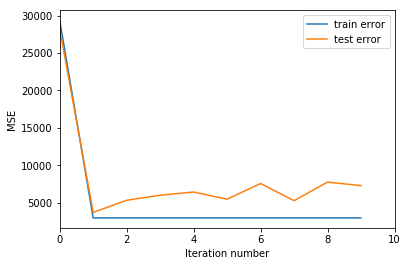

In [15]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [16]:
n_trees = 100
coefs = [1] * n_trees

# %%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [17]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2959.823489875405
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тестовой выборке: 9303.282178127805


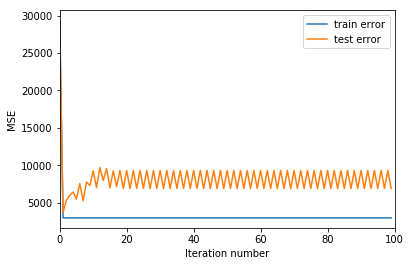

In [18]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [19]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [20]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 363.4906314701368
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3699.669565648913


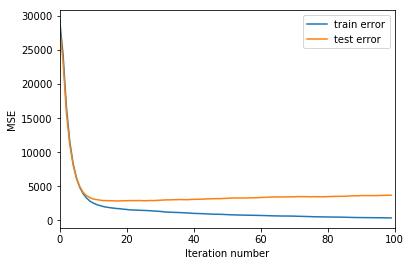

In [21]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [22]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [23]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 2582.492140223729
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 3326.289243455896


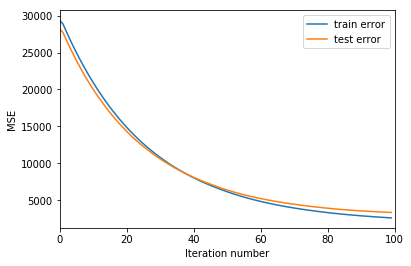

In [24]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [25]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [26]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 4.494365661741232
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3819.2003984335147


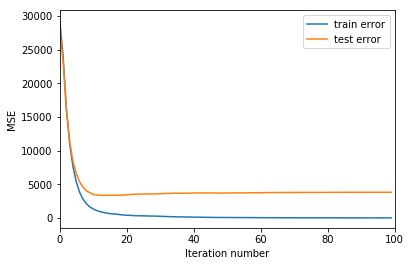

In [27]:
get_error_plot(n_trees, train_errors, test_errors)

## AdaBoost

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [29]:
X, y = load_breast_cancer(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [30]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем функцию подсчета ошибки

In [31]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [32]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [33]:
N = 50

models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [34]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 98.592


In [35]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 92.308


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

In [36]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

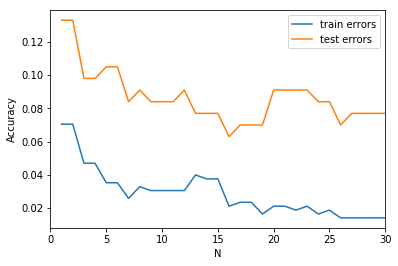

In [37]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

### Домашнее задание:  
1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.  
2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

### 1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.  

### Провел оптимизацию кода, так как мой ноутбук слишком долго считал примеры, приведенные выше

In [92]:
X, y = load_diabetes(return_X_y=True)

In [93]:
X.shape

(442, 10)

In [94]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [95]:
def mean_squared_error_1(y_real, prediction):
    return np.mean((y_real - prediction)**2)

In [123]:
def gb_predict_1(X, trees_list, coef_list, eta):
    result = np.zeros(X.shape[0])
    cnt = 0
    #print(cnt)
    for tree in trees_list:
        result += eta*coef_list[cnt]*tree.predict(X)
        cnt += 1
    return result

In [97]:
def evaluate_alg_1(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict_1(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error_1(y_train, train_prediction)}')

    test_prediction = gb_predict_1(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error_1(y_test, test_prediction)}')

In [98]:
def gb_fit_1(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = np.zeros(n_trees)
    test_errors = np.zeros(n_trees)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if i == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            trees.append(tree)
            train_errors[0] = mean_squared_error_1(y_train, gb_predict_1(X_train, trees, coefs, eta))
            test_errors[0] = mean_squared_error_1(y_test, gb_predict_1(X_test, trees, coefs, eta))
            
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict_1(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors[i] = mean_squared_error_1(y_train, gb_predict_1(X_train, trees, coefs, eta))
            test_errors[i] = mean_squared_error_1(y_test, gb_predict_1(X_test, trees, coefs, eta))

        trees.append(tree)
        
    return trees, train_errors, test_errors

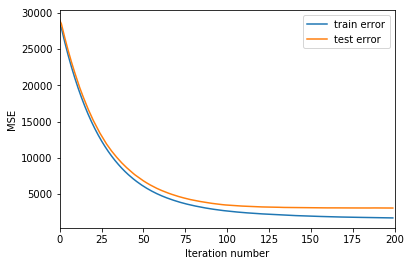

Ошибка алгоритма из 200 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 1695.589374768075
Ошибка алгоритма из 200 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 3067.6238618657767


In [175]:
eta = 0.01
n_trees = 200
coefs = np.ones(n_trees + 1)
max_depth = 3
trees, train_errors, test_errors = gb_fit_1(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors)
evaluate_alg_1(X_train, X_test, y_train, y_test, trees, coefs, eta)

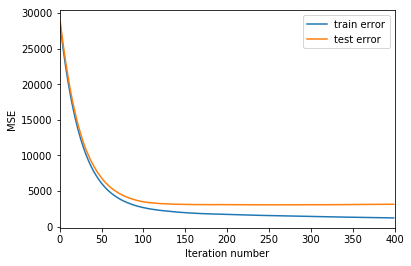

Ошибка алгоритма из 400 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 1203.8057146616839
Ошибка алгоритма из 400 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 3134.3773392101803


In [177]:
eta = 0.01
n_trees = 400
coefs = np.ones(n_trees + 1)
max_depth = 3
trees, train_errors, test_errors = gb_fit_1(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors)
evaluate_alg_1(X_train, X_test, y_train, y_test, trees, coefs, eta)

#### С увеличением количества деревьев (итераций) проявляется эффект переобучения: ошибка на тестовом наборе начинает увеличиваться

In [178]:
depth_array = [1, 2, 3, 4, 5, 6] 
eta = 0.01
n_trees = 200
coefs = np.ones(n_trees + 1)

In [179]:
train_error_end = []
test_error_end = []
for max_depth in depth_array:
    trees, train_errors, test_errors = gb_fit_1(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_error_end.append(train_errors[-1])
    test_error_end.append(test_errors[-1])

In [180]:
train_error_end

[2934.0059408992743,
 2322.4760688155925,
 1699.4358375414934,
 1022.7037999928558,
 522.9543328240028,
 203.5329549511426]

In [181]:
test_error_end

[3115.1277525890027,
 2887.9380925965365,
 3063.8031804047223,
 3165.676575818455,
 3264.903143863495,
 3344.0925364010313]

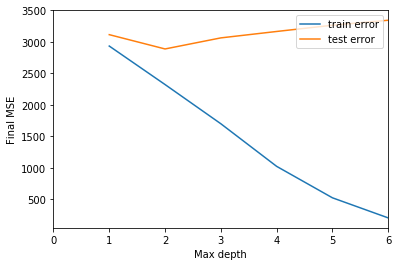

In [182]:
plt.xlabel('Max depth')
plt.ylabel('Final MSE')
plt.xlim(0, len(train_error_end))
plt.plot(depth_array, train_error_end, label='train error')
plt.plot(depth_array, test_error_end, label='test error')
plt.legend(loc='upper right')
plt.show()

#### Максимальная глубина деревьем имеет оптимальное значение, равное 2 

### 2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [229]:
def gb_fit_2(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, bootstap = 0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = np.zeros(n_trees)
    test_errors = np.zeros(n_trees)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        bootstrap_idx = np.random.choice(np.arange(X_train.shape[0]), int(X_train.shape[0]*bootstap), replace=False, p=None) 
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if i == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[bootstrap_idx], y_train[bootstrap_idx])
            trees.append(tree)
            train_errors[0] = mean_squared_error_1(y_train, gb_predict_1(X_train, trees, coefs, eta))
            test_errors[0] = mean_squared_error_1(y_test, gb_predict_1(X_test, trees, coefs, eta))
            
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict_1(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[bootstrap_idx], deriv(y_train[bootstrap_idx], pred[bootstrap_idx]))
            
            train_errors[i] = mean_squared_error_1(y_train, gb_predict_1(X_train, trees, coefs, eta))
            test_errors[i] = mean_squared_error_1(y_test, gb_predict_1(X_test, trees, coefs, eta))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [231]:
eta = 0.01
n_trees = 200
coefs = np.ones(n_trees + 1)
max_depth = 3
trees, train_errors_1, test_error_1 = gb_fit_2(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, bootstap = 0.5)
trees, train_errors_2, test_error_2 = gb_fit_2(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, bootstap = 1)

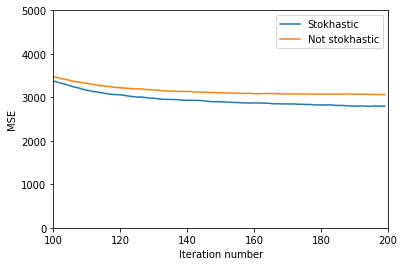

In [238]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(n_trees/2, n_trees)
plt.ylim(0, 5000)
plt.plot(list(range(n_trees)), test_error_1, label='Stokhastic')
plt.plot(list(range(n_trees)), test_error_2, label='Not stokhastic')
plt.legend(loc='upper right')
plt.show()

#### Из графика видно, что у стохастического градиентного бустинга точность выше